# How can we best leverage AirBnB reviews while making bookings?

## Background

### Motivation
AirBnB is a popular platform that connects travelers with hosts who offer various types of accommodation, from private rooms to entire homes. With millions of listings worldwide, finding the right place to stay can be overwhelming and time-consuming. How can customers make sure that they are getting the best value for your money and that their expectations are met?

One way to do that is to leverage the reviews that previous guests have left for the listings. Reviews are a rich source of information that can reveal a lot about each accommodation. However, reading through hundreds or thousands of reviews can also be tedious and impractical. This project aims to combat that use natural language processing (NLP) techniques to analyse and summarize AirBnB reviews, and to determine if the ratings correlate to the sentiment of the reviews.

### Overview
In this project, I used a dataset of AirBnB listings and reviews from London, UK obtained from [Inside AirBnB](http://insideairbnb.com/get-the-data.html). The first section includes an exploratory data analysis to find some trends and patterns in the listings, such as the distribution of prices, ratings, and locations. 

The second part uses sentence embeddings to determine the correlation between the ratings of the listings and their reviews.

The main part of the project was to use a Large Language Model (LLM) to summarize all the reviews for each listing into bullet points. In this project, a LLM was used to extract the most relevant and important information from the reviews, such as the cleanliness, comfort, location, amenities, and host communication of each listing. This summary allows customers to gauge the suitability of the property at a glance.

### Business Questions
 - What are the main factors that infuence the monthly revenue of AirBnB hosts?
 - Do the review scores for each listing reflect the reviews provided by customers?
 - Can we reduce the time customers spend on reading reviews through summarization?

### Findings
To learn more about the findings, [click here to read the blog post](https://kelvinchanwh.com/projects/airbnb-description)

### Limitations
 - The analysis done here assumes that the data is taken at a given time and does not take into account seasonality and other factors that may affect the price. Thus, the values are only accurate at time of analysis. It is **NOT ADVISED** to use the prices found as a benchmark for your upcoming trip. 



## Exploratory Data Analysis
### Load Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

listings_full = pd.read_csv("data/listings_full.csv")
reviews_full = pd.read_csv("data/reviews_full.csv")


In [3]:
listings_full.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,198258,https://www.airbnb.com/rooms/198258,20231210055232,2023-12-10,city scrape,Rental unit in Barking · ★4.74 · 1 bedroom · 1...,NaN,"I live in Barking town centre, at one time the...",https://a0.muscache.com/pictures/airflow/Hosti...,967537,...,4.88,4.45,4.68,NaN,f,1,0,1,0,0.27
1,33332,https://www.airbnb.com/rooms/33332,20231210055232,2023-12-10,city scrape,"Home in St Margaret's, Isleworth · ★4.40 · 1 ...",NaN,Peaceful and friendly.,https://a0.muscache.com/pictures/miso/Hosting-...,144444,...,4.53,4.68,4.26,NaN,f,2,0,2,0,0.12
2,42010,https://www.airbnb.com/rooms/42010,20231210055232,2023-12-10,city scrape,Home in East Finchley · ★4.88 · 1 bedroom · 1 ...,NaN,We have a unique cinema called the Phoenix whi...,https://a0.muscache.com/pictures/airflow/Hosti...,157884,...,4.95,4.73,4.87,NaN,t,2,0,2,0,3.45
3,284603,https://www.airbnb.com/rooms/284603,20231210055232,2023-12-11,previous scrape,Rental unit in London · ★4.83 · 1 bedroom · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/3246231/8e9b1...,1481851,...,5.00,5.00,4.83,NaN,f,1,1,0,0,0.04
4,89870,https://www.airbnb.com/rooms/89870,20231210055232,2023-12-10,city scrape,Rental unit in London · ★4.65 · 1 bedroom · 1 ...,NaN,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.91,4.73,4.50,NaN,f,3,2,1,0,0.89


In [4]:
listings_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91778 entries, 0 to 91777
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            91778 non-null  int64  
 1   listing_url                                   91778 non-null  object 
 2   scrape_id                                     91778 non-null  int64  
 3   last_scraped                                  91778 non-null  object 
 4   source                                        91778 non-null  object 
 5   name                                          91778 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         48999 non-null  object 
 8   picture_url                                   91767 non-null  object 
 9   host_id                                       91778 non-null 

### Data Cleaning
Here we conduct simple data cleaning by removing unused columns, converting bool and numerical features etc.

In [6]:
# Drop unused columns
listings_drop = listings_full.drop(
    [
        "listing_url",
        "scrape_id",
        "last_scraped",
        "source",
        "name",
        "description",
        "picture_url",
        "host_url",
        "host_thumbnail_url",
        "host_picture_url",
		"host_verifications",
        "neighbourhood",
        "neighbourhood_group_cleansed",
        "amenities",
        "minimum_minimum_nights",
        "maximum_minimum_nights",
        "minimum_maximum_nights",
        "maximum_maximum_nights",
        "minimum_nights_avg_ntm",
        "maximum_nights_avg_ntm",
        "calendar_updated",
        "calendar_last_scraped",
        "license",
        'host_name', 
        'property_type',
        'bathrooms',
        'bedrooms'
    ], axis=1
)


In [7]:
# Clean up listings df
listings = listings_drop.copy()
null_to_bool = ["neighborhood_overview", "host_location", "host_about", "host_neighbourhood"]
for col in null_to_bool:
    listings[f"has_{col}"] = listings[col].notnull()
listings = listings.drop(null_to_bool, axis=1)

boolean = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"]
for col in boolean:
    listings[col] = listings[col].replace({"f": False, "t": True}).fillna(False)

percentage = ["host_response_rate", "host_acceptance_rate"]
for col in percentage:
    listings[col] = pd.to_numeric(
        listings[col].apply(lambda x: x.replace("%", "") if isinstance(x, str) else x)
    )

categorical = ["neighbourhood_cleansed", "room_type"]
for col in categorical:
    dummies = pd.get_dummies(listings[col], prefix=col, prefix_sep="_")

# Parse review timeline
dates = ['first_review', 'last_review', 'host_since']
snapshot_date = pd.to_datetime("2023-12-10", format="%Y-%m-%d")

for col in dates:
    listings[col] = pd.to_datetime(listings[col], format="%Y-%m-%d")
    listings[f"{col}_days"] = (
        pd.to_datetime(listings[col], format="%Y-%m-%d") - snapshot_date
    ) / np.timedelta64(1, "D")
    listings[col].astype(int)
listings = listings.drop(dates, axis = 1)

# Convert response time to ordinal categorical
listings["host_response_time"] = listings["host_response_time"].replace(
    {
        "within an hour": 0,
        "within a few hours": 1,
        "within a day": 2,
        "a few days or more": 3,
    }
)

# Parse bathrooms_text
listings["bathrooms"] = listings["bathrooms_text"].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float).fillna(1)
listings = listings.drop("bathrooms_text", axis=1)

# Parse price
listings["price"] = pd.to_numeric(listings["price"].apply(lambda x: x.replace("$", "").replace(",", "") if isinstance(x, str) else x))

# Remove listings with 0 availability as it is highly likely the property owner has placed the property as unavailable
listings = listings[listings["availability_30"] != 0]

listings_clean = listings.dropna(axis=0, how="any").reset_index()


/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_5907/2893372191.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listings[col] = listings[col].replace({"f": False, "t": True}).fillna(False)
/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_5907/2893372191.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listings[col] = listings[col].replace({"f": False, "t": True}).fillna(False)
/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_5907/2893372191.py:35: FutureWarning: Downcasting behavior in `replace` is depr

In [8]:
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35318 entries, 0 to 35317
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         35318 non-null  int64  
 1   id                                            35318 non-null  int64  
 2   host_id                                       35318 non-null  int64  
 3   host_response_time                            35318 non-null  float64
 4   host_response_rate                            35318 non-null  float64
 5   host_acceptance_rate                          35318 non-null  float64
 6   host_is_superhost                             35318 non-null  bool   
 7   host_listings_count                           35318 non-null  float64
 8   host_total_listings_count                     35318 non-null  float64
 9   host_has_profile_pic                          35318 non-null 

### Most important features
Here we determine the most important factors which influence the price and availability of listings. Although we first look at price and availability, we eventually determine that monthly revenue (# of days booked * price per night) is the best metric to evaluate listings. This is because prices are set by the user and does not reflect the demand for the property. 

In [7]:
price_corr = listings_clean.corrwith(listings_clean.price, numeric_only=True).abs().sort_values(ascending=False)[1:]
print ("Price Correlation")
print(price_corr[price_corr > 0.1])

Price Correlation
accommodates                                   0.421537
beds                                           0.345322
bathrooms                                      0.335523
calculated_host_listings_count_entire_homes    0.272089
calculated_host_listings_count                 0.249292
host_listings_count                            0.162451
host_total_listings_count                      0.112173
has_host_neighbourhood                         0.108942
reviews_per_month                              0.107116
number_of_reviews_l30d                         0.104555
number_of_reviews_ltm                          0.104282
dtype: float64


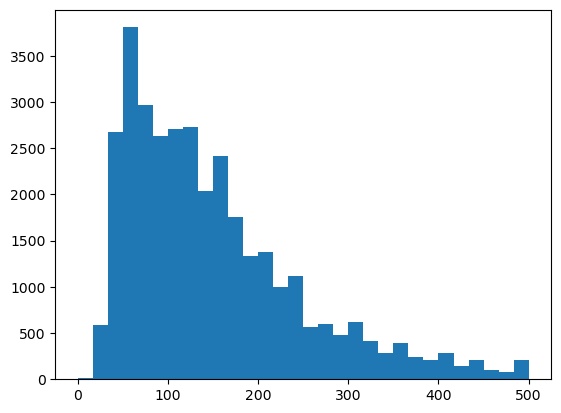

In [8]:
plt.hist(listings_clean.price, range=(0, 500), bins=30);

In [9]:
avail_30_corr = listings_clean.corrwith(listings_clean["availability_30"], numeric_only=True).abs().sort_values(ascending=False)[1:]
print ("Availability (Month)")
print(avail_30_corr[avail_30_corr > 0.1])

Availability (Month)
availability_60                0.811603
availability_90                0.686468
availability_365               0.350831
number_of_reviews_ltm          0.184604
number_of_reviews_l30d         0.182026
reviews_per_month              0.168048
review_scores_value            0.161702
number_of_reviews              0.154639
review_scores_accuracy         0.152962
review_scores_rating           0.147935
host_since_days                0.137614
review_scores_communication    0.137461
host_id                        0.132476
host_response_rate             0.130214
review_scores_checkin          0.124928
review_scores_cleanliness      0.123253
review_scores_location         0.107101
host_listings_count            0.105798
last_review_days               0.104012
dtype: float64


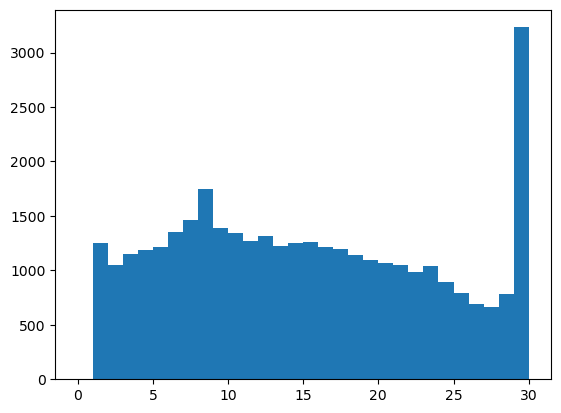

In [10]:
plt.hist(listings_clean.availability_30, range=(0, 30), bins=30);

In [11]:
listings_clean["month_revenue"] = listings_clean["price"] * (30 - listings_clean["availability_30"])

In [12]:
rev_corr = listings_clean.corrwith(listings_clean["month_revenue"], numeric_only=True).abs().sort_values(ascending=False)[1:]
print ("Montly Revenue")
print(rev_corr[rev_corr > 0.1])

Montly Revenue
price                                          0.698216
accommodates                                   0.385408
availability_30                                0.377677
beds                                           0.316429
availability_60                                0.294294
bathrooms                                      0.293720
availability_90                                0.247727
review_scores_location                         0.119298
calculated_host_listings_count_entire_homes    0.101932
dtype: float64


From the correlations, we can see that the factors which directly affect the price are:
- Number of people the property accommodates (# of beds)
- Number of bathrooms
- Type of property (Private room, Entire home etc.)
- Number of other listings by host
- Neighbourhood
- Number of Reviews

Factors which directly affect the number of monthly bookings are:
- Number of Reviews
- Property review rating
- Host response rate & time
- Host account age

Assuming that the revenue for the month is based on the number of nights booked and the price set, the factors which affect the revenue are:
- Number of people the property accommodates (# of beds)
- Number of bathrooms
- Type of property (Private room, Entire home etc.)
- Neighbourhood
- Property review rating

### How does the top factors influence the monthly revenue?
Here we determine the relationship between the top factors and monthly revenue. (i.e. Does the revenue increase as the factors increase? Is the relationship linear? etc.)

/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


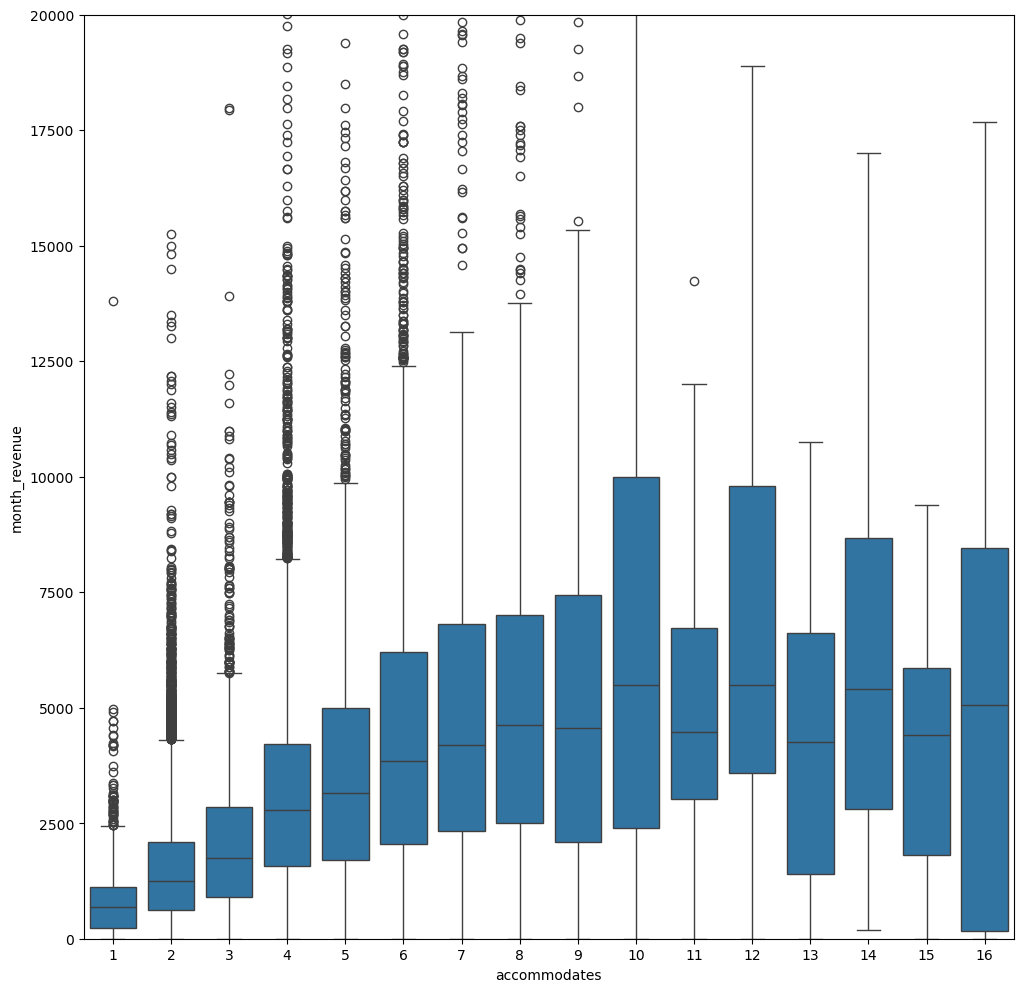

In [13]:
# Plotting a boxplot to quickly see if there is any trend between price and accomodates
plt.figure(figsize=(12,12))
plt.ylim(0, 20000)
sns.boxplot(x='accommodates', y='month_revenue', data=listings_clean[listings_clean["accommodates"] <= 20][["accommodates", "month_revenue"]]);

/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


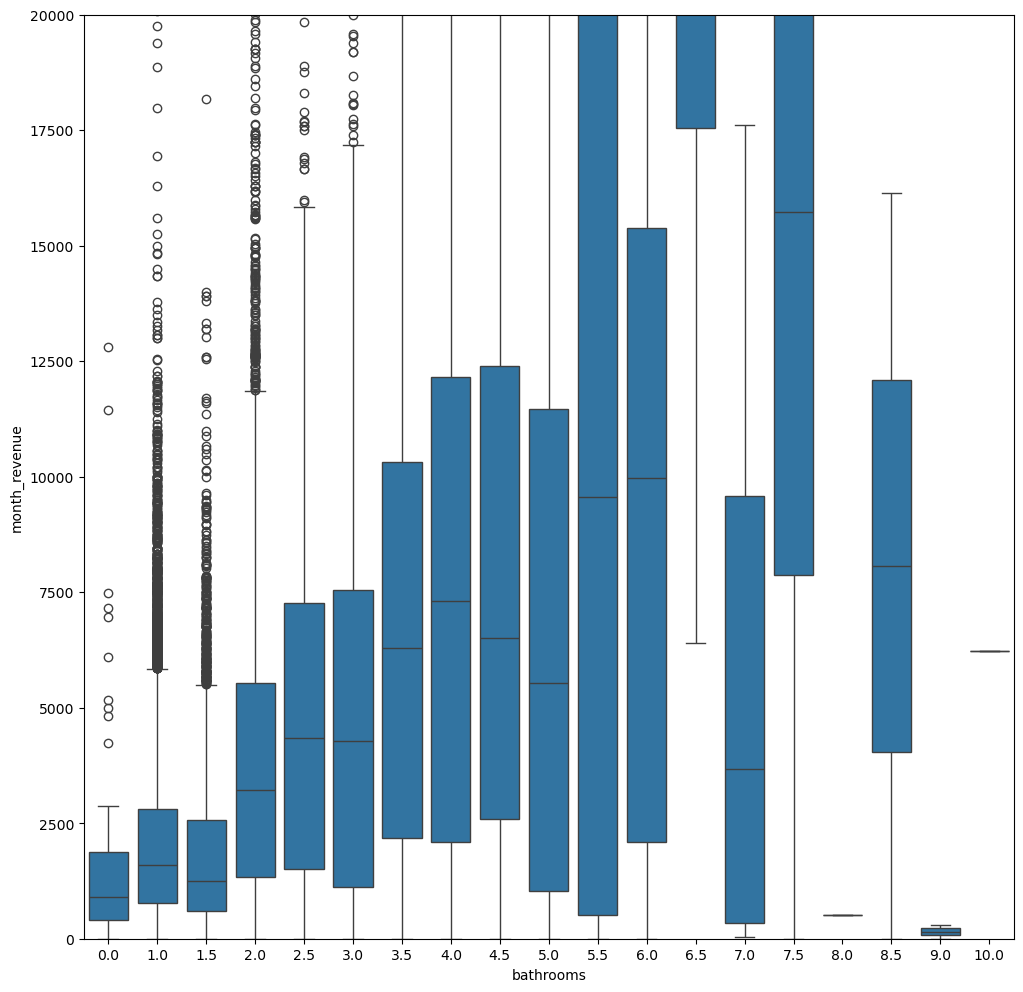

In [14]:
# Plotting a boxplot to quickly see if there is any trend between price and no. bathrooms
plt.figure(figsize=(12,12))
plt.ylim(0, 20000)
sns.boxplot(x='bathrooms', y='month_revenue', data=listings_clean[listings_clean["bathrooms"] <= 10][["bathrooms", "month_revenue"]]);

From the graphs above, we can see that the price of the properties seem to follow a linear relationship to the number of people the property accomodates and number of bathrooms. This is true up till about 8 people or 4 bathrooms. After that, the price of the property stays fairly constant (about £5000) regardless of the number of people it accomodates or the number of bathrooms. This indicates that the maximum revenue an an average property owner can expect to earn through AirBnB is $5000. 

<Axes: xlabel='accommodates', ylabel='room_type'>

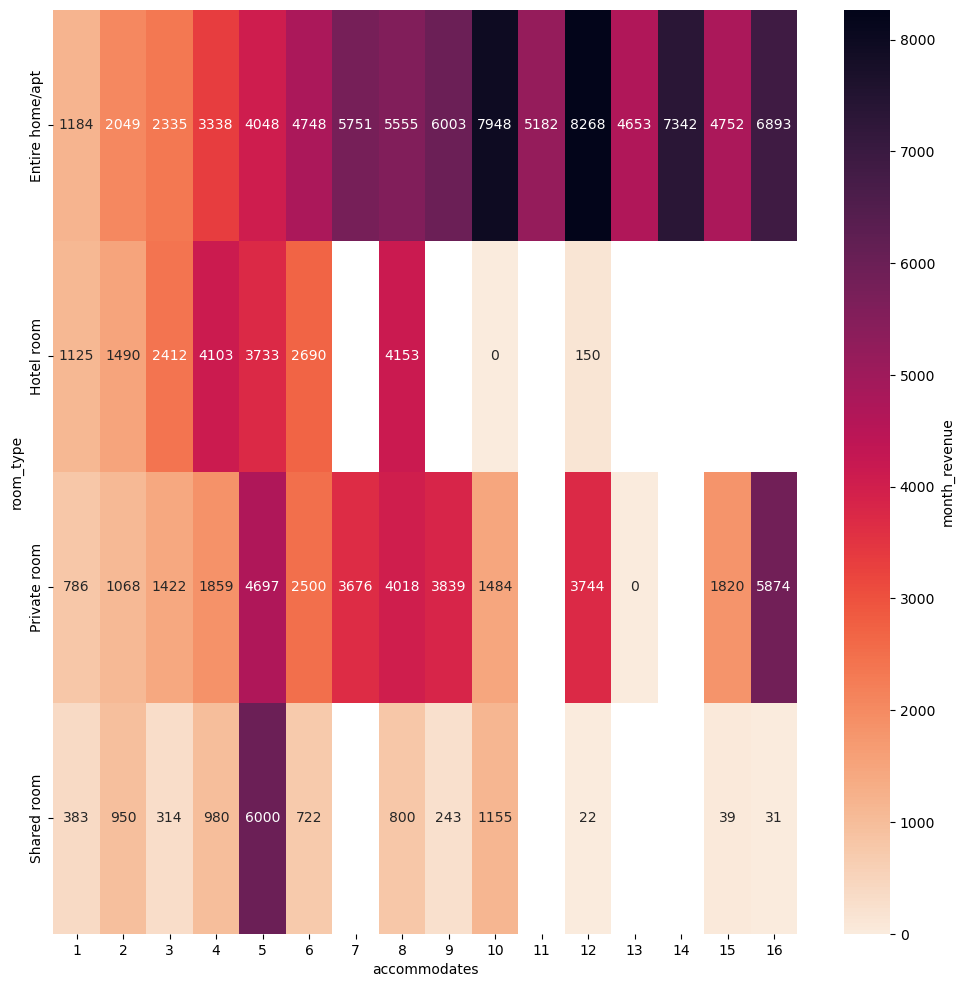

In [15]:
# Plotting a heatmap of prices with number of bedrooms for listings

plt.figure(figsize=(12,12))
sns.heatmap(listings_clean.groupby(['room_type', 'accommodates']).month_revenue.mean().unstack(),annot=True, fmt=".0f", cmap = sns.cm.rocket_r, cbar_kws={'label': 'month_revenue'})

<Axes: xlabel='accommodates', ylabel='room_type'>

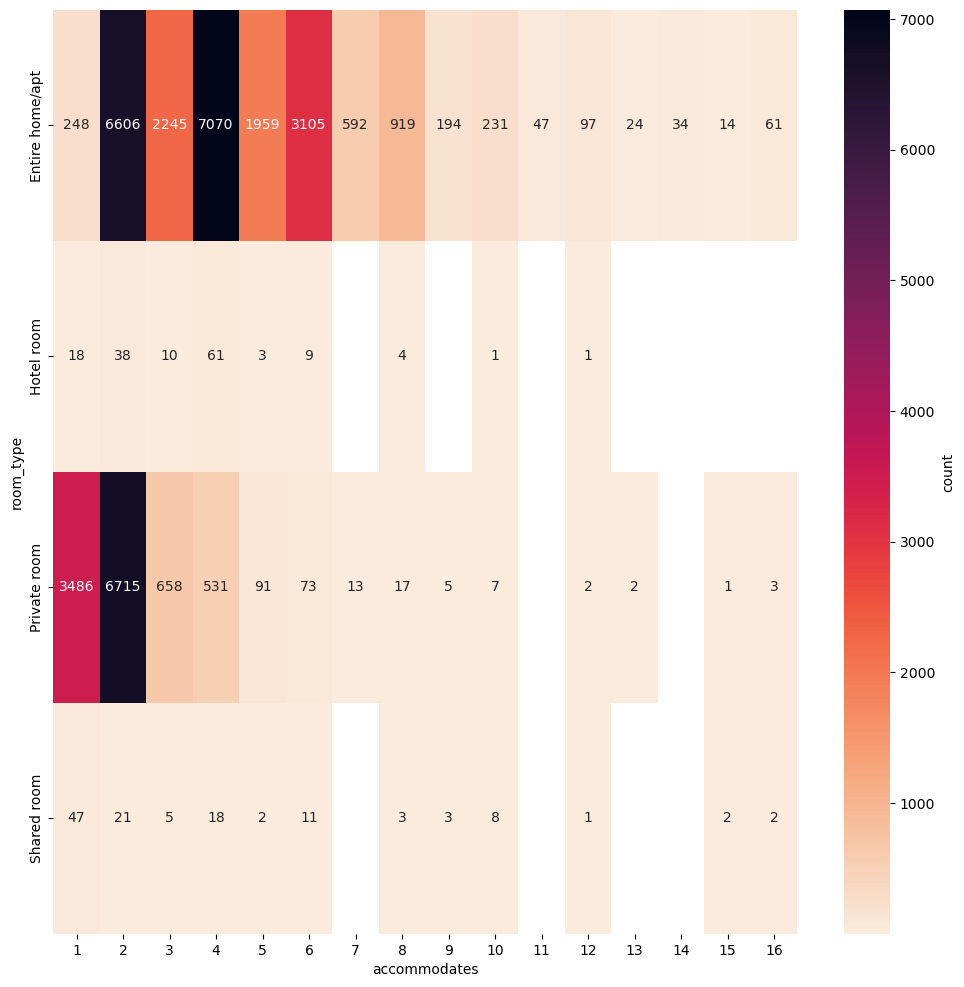

In [16]:
# Plotting a heatmap of listings with number of bedrooms

plt.figure(figsize=(12,12))
sns.heatmap(listings_clean.groupby(['room_type', 'accommodates']).month_revenue.count().unstack(),annot=True, fmt=".0f", cmap = sns.cm.rocket_r, cbar_kws={'label': 'count'})

<Axes: xlabel='accommodates', ylabel='room_type'>

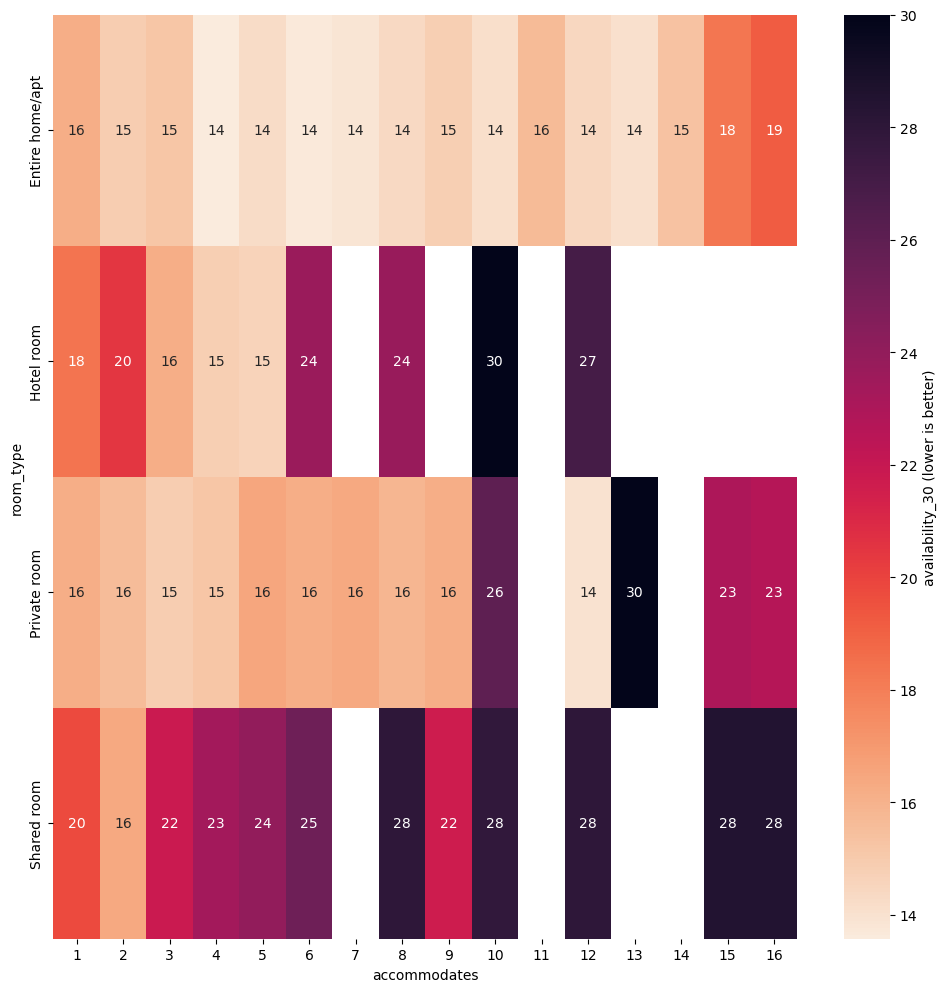

In [17]:
# Plotting a heatmap of listings with number of bedrooms

plt.figure(figsize=(12,12))
sns.heatmap(listings_clean.groupby(['room_type', 'accommodates']).availability_30.mean().unstack(),annot=True, fmt=".0f", cmap = sns.cm.rocket_r, cbar_kws={'label': 'availability_30 (lower is better)'})

<Axes: xlabel='accommodates', ylabel='room_type'>

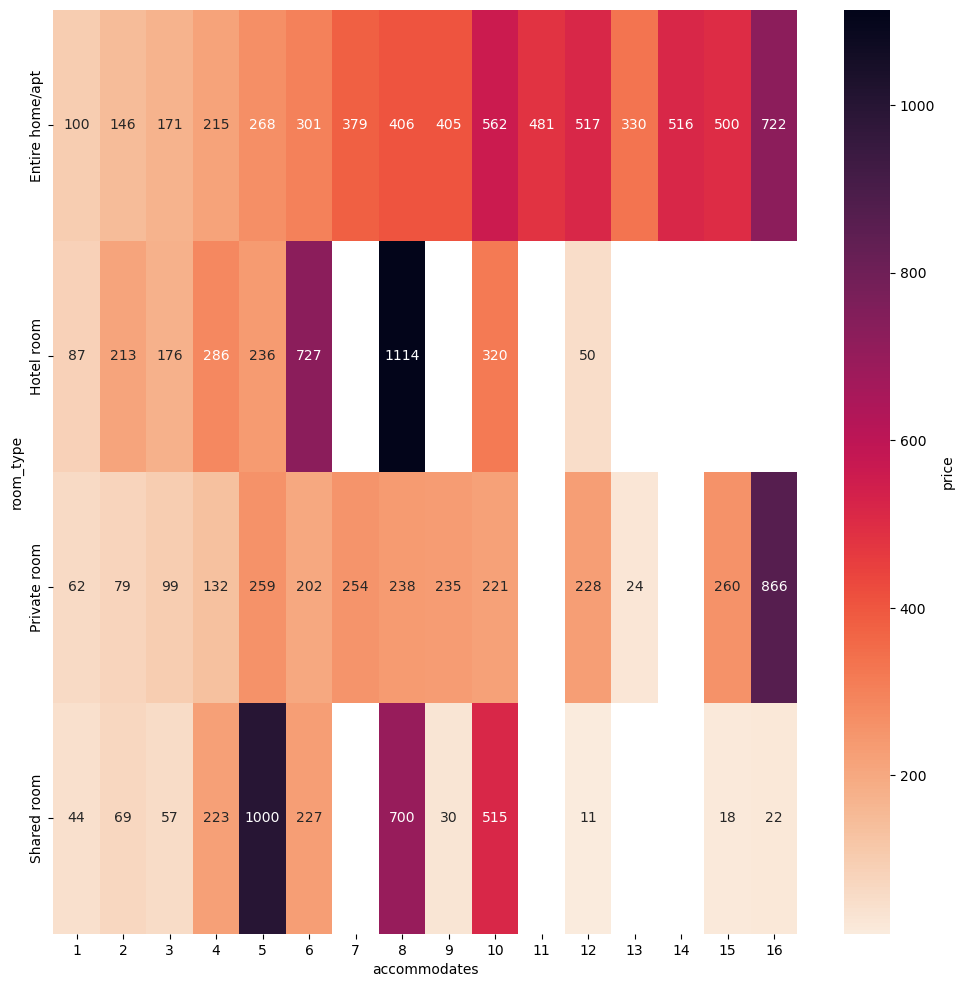

In [18]:
# Plotting a heatmap of listings with number of bedrooms

plt.figure(figsize=(12,12))
sns.heatmap(listings_clean.groupby(['room_type', 'accommodates']).price.mean().unstack(),annot=True, fmt=".0f", cmap = sns.cm.rocket_r, cbar_kws={'label': 'price'})

From the boxplot, we can identify a few trends:
- Travellers with > 4 guests usually opt for entire homes
	- When travelling with > 4 guests, customers usually book entire homes compared to private rooms. This can be seen by the monthly revenue for private rooms which drop significantly after 4 guests. 
	- The high number of private rooms which accomodate 1 to 2 guests also shows that many hosts are likely listing their spare rooms on AirBnB. Nonetheless, these spare rooms are not as popular among customers as seen through the low booking rate.
- For travellers <= 4 guests, the distribution between entire homes and private rooms are fairly balanced
	- Despite the price difference between entire homes and private rooms (~1.6x), the availability of both types of properties are fairly similar for <= 4 guests
- Most accomodations accomodate an even number of guests
	- The number of listings for even number of guests are much higher compared to odd number of guests for all property types

In this analysis, we only look into entire homes and private rooms since those are the properties with sufficient data to provide us with any insights. 

/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_78681/1604008500.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90);


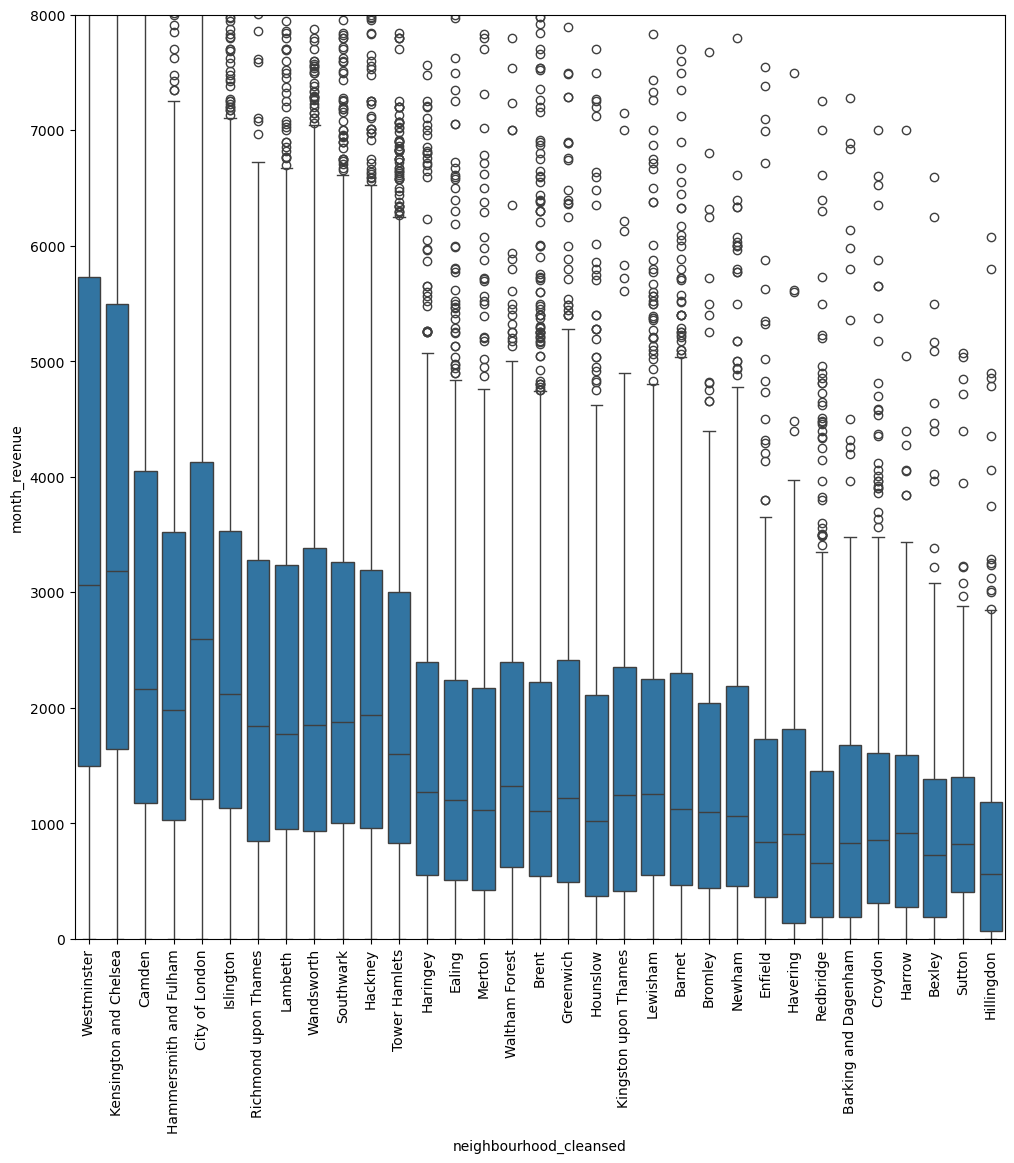

In [19]:
# Plotting a boxplot to quickly see if there is any trend between price and neighbourhoods
plt.figure(figsize=(12,12))
plt.ylim(0, 8000)
ax = sns.boxplot(x='neighbourhood_cleansed', y='month_revenue', data=listings_clean[["neighbourhood_cleansed", "month_revenue"]], order=listings_clean.groupby("neighbourhood_cleansed")["month_revenue"].mean().sort_values(ascending=False).keys())
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_78681/2927671092.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90);


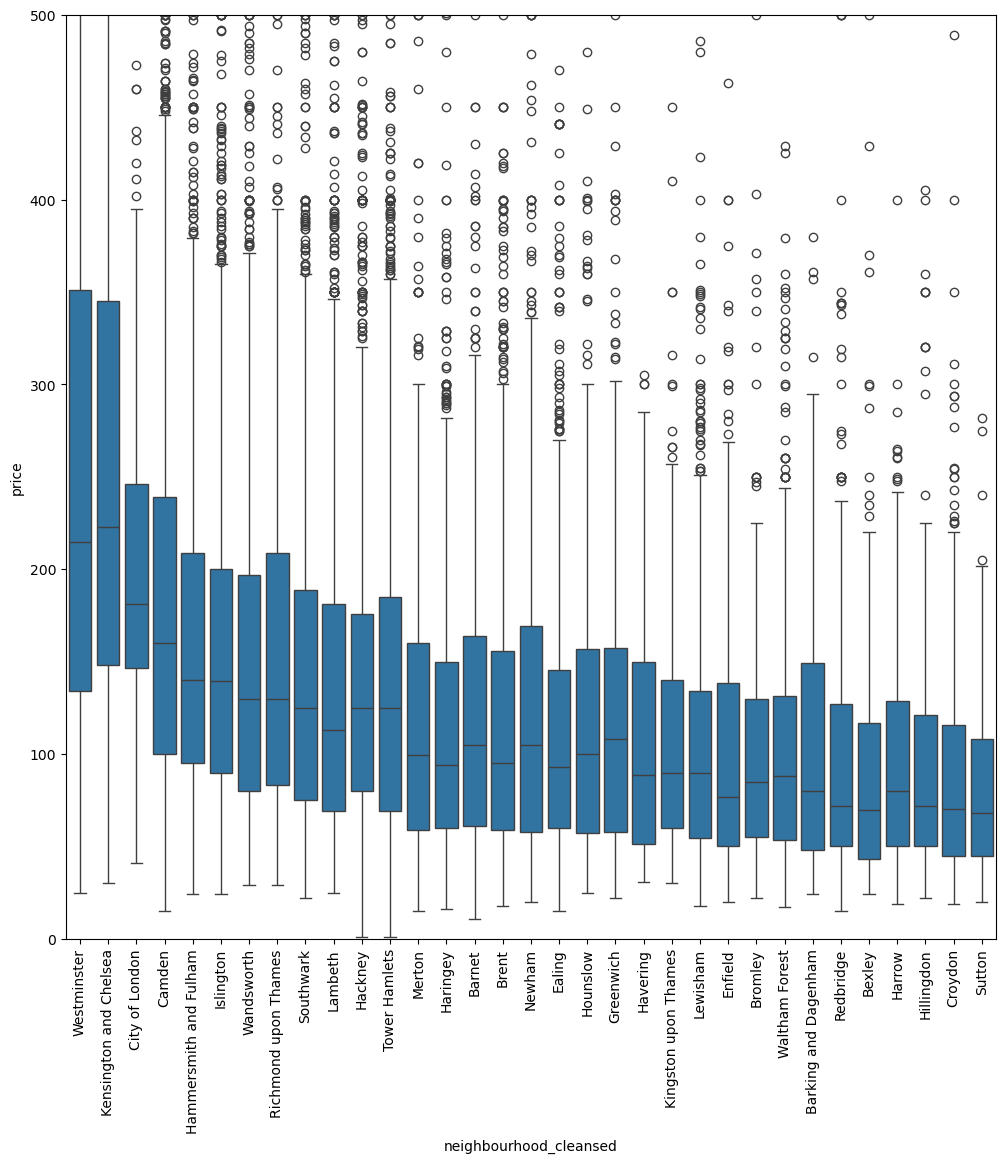

In [20]:
# Plotting a boxplot to quickly see if there is any trend between price and neighbourhoods
plt.figure(figsize=(12,12))
plt.ylim(0, 500)
ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=listings_clean[["neighbourhood_cleansed", "price"]], order=listings_clean.groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=False).keys())
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_78681/3920043734.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90);


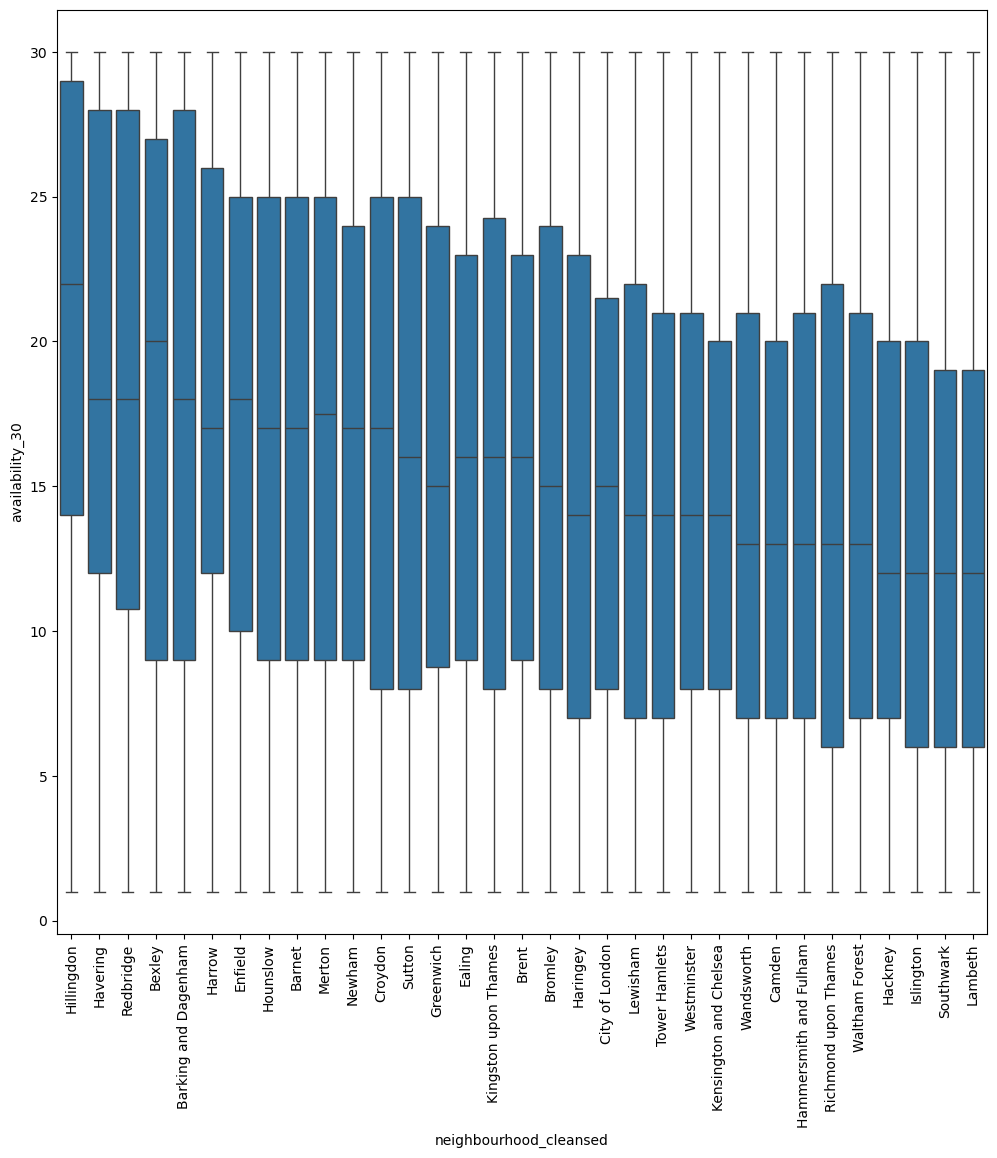

In [21]:
# Plotting a boxplot to quickly see if there is any trend between price and neighbourhoods
plt.figure(figsize=(12,12))
ax = sns.boxplot(x='neighbourhood_cleansed', y='availability_30', data=listings_clean[["neighbourhood_cleansed", "availability_30"]], order=listings_clean.groupby("neighbourhood_cleansed")["availability_30"].mean().sort_values(ascending=False).keys())
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

From this boxplot, we can see that Westminster is the neighbourhood with the highest monthly revenue followed by Kensington and Chelsea, Camden, Hammersmith and Fulham, and City of London. 

/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_78681/4112627477.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90);


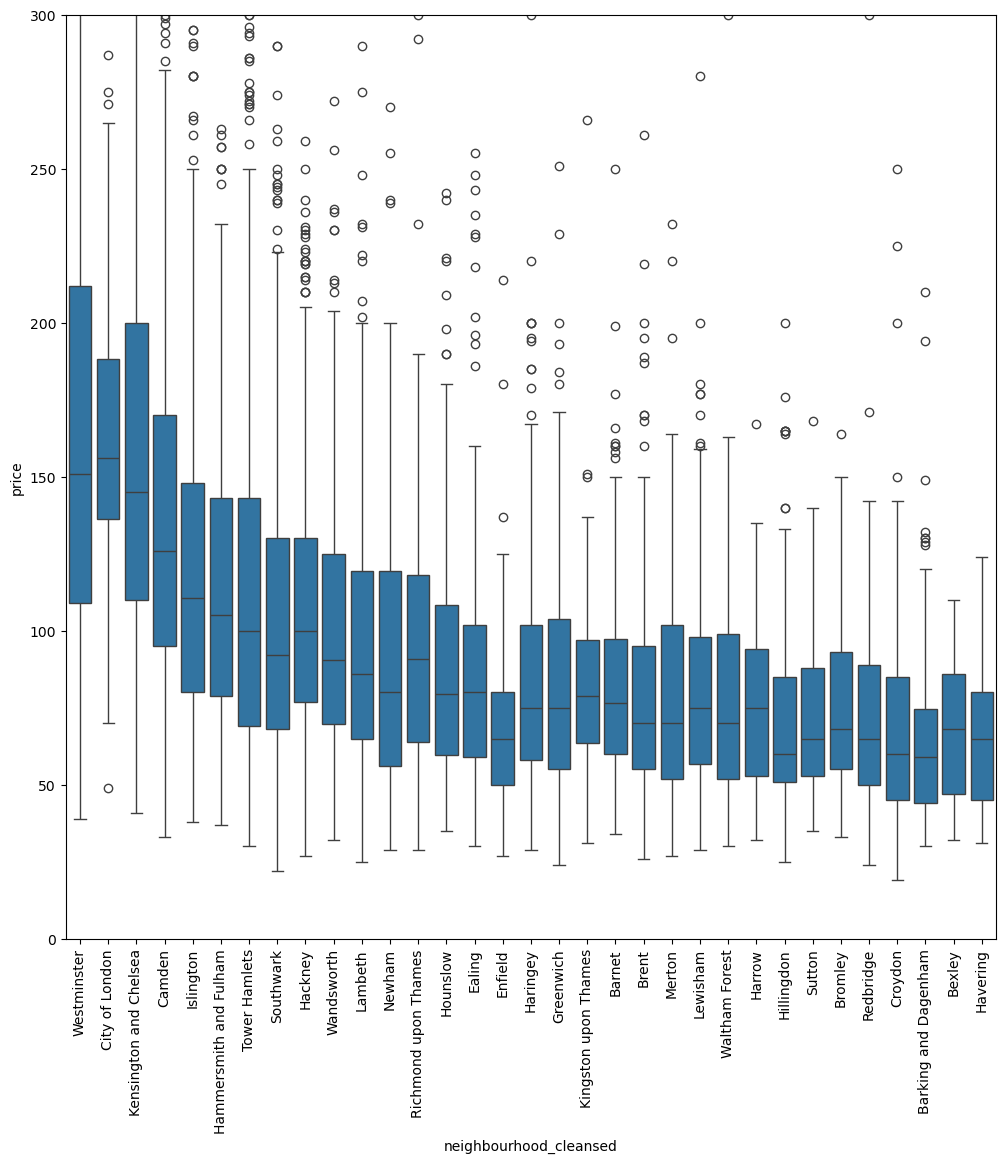

In [23]:
# Plotting a boxplot to quickly see if there is any trend between price and neighbourhoods
plt.figure(figsize=(12,12))
plt.ylim(0, 300)
ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=listings_clean[(listings_clean["accommodates"] == 2) & (listings_clean["bathrooms"] == 1)][["neighbourhood_cleansed", "price"]], order=listings_clean[(listings_clean["accommodates"] == 2) & (listings_clean["bathrooms"] == 1)].groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=False).keys())
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

## Review Score Correlation
In this section, we use a pre-trained sentence embedding model to extract embeddings from the reviews. We then train a regression model to predict between the listing scores and the reviews given. Using this model, we determine the correlation between the reviews and their corresponding listing scores.

### Merge Reviews and Listings

In [9]:
score_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location', 'review_scores_value', 'price']

merged = pd.merge(reviews_full[["listing_id", "reviewer_id", "comments"]], listings_clean[score_cols + ["id"]], how="inner", left_on="listing_id", right_on="id", validate="many_to_one").drop("id", axis=1).dropna()

In [10]:
merged.head()

,listing_id,reviewer_id,comments,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,13913,177109,My girlfriend and I hadn't known Alina before ...,4.8,4.73,4.73,4.75,4.83,4.7,4.7,70.0
1,13913,19835707,Alina was a really good host. The flat is clea...,4.8,4.73,4.73,4.75,4.83,4.7,4.7,70.0
2,13913,1110304,Alina is an amazing host. She made me feel rig...,4.8,4.73,4.73,4.75,4.83,4.7,4.7,70.0
3,13913,1216358,"Alina's place is so nice, the room is big and ...",4.8,4.73,4.73,4.75,4.83,4.7,4.7,70.0
4,13913,490840,"Nice location in Islington area, good for shor...",4.8,4.73,4.73,4.75,4.83,4.7,4.7,70.0


### Filter English Comments Only

In [5]:
import spacy
from tqdm import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)


# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
from langdetect import detect_langs
def detect_language_with_langdetect(line): 
    try: 
        langs = detect_langs(line)[0]
        # The first one returned is usually the one that has the highest probability
        if langs.prob > 0.9999:
            return langs.lang
        else:
            return "unk"
    except:
         return "err"

In [13]:
review_merged = merged
review_merged["language"] = review_merged["comments"].parallel_apply(detect_language_with_langdetect)

In [14]:
review_merged = review_merged[review_merged["language"] == "en"].reset_index()

In [15]:
review_merged.count()

index                          824501
listing_id                     824501
reviewer_id                    824501
comments                       824501
review_scores_rating           824501
review_scores_accuracy         824501
review_scores_cleanliness      824501
review_scores_checkin          824501
review_scores_communication    824501
review_scores_location         824501
review_scores_value            824501
price                          824501
language                       824501
dtype: int64

### Build prediction model

In [31]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForMaskedLM

X = review_merged["comments"].values
y = review_merged["review_scores_rating"].values


In [32]:
split_id = 47990252

train_df = review_merged[review_merged["listing_id"] <= split_id]
test_df = review_merged[review_merged["listing_id"] > split_id]

X_train = train_df["comments"].values
y_train = train_df["review_scores_rating"].values

X_test = test_df["comments"].values
y_test = test_df["review_scores_rating"].values


In [33]:
# Load a pre-trained sentence embeddings model (e.g., 'paraphrase-MiniLM-L6-v2')
model_name = 'all-MiniLM-L12-v2'

model = SentenceTransformer(model_name, device='mps')
X_train_embeddings = model.encode(X_train, show_progress_bar=True, device='mps', normalize_embeddings=True)
X_test_embeddings = model.encode(X_test, show_progress_bar=True, device='mps', normalize_embeddings=True)


/Users/Kelvin.K.Chan2/miniforge3/envs/udacity/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Batches:   0%|          | 0/18040 [00:00<?, ?it/s]

Batches:   0%|          | 0/7729 [00:00<?, ?it/s]

In [34]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import gc

y_cols = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']
y_results = {}

def prep_dataset(X_train_embeddings, y_train, X_test_embeddings, y_test):
	print (f"Evaluating Correlation between comments and {col}")
	X_train_group = pd.DataFrame(X_train_embeddings).join(train_df["listing_id"]).groupby("listing_id").mean().values
	y_train_group = pd.DataFrame(y_train).join(train_df["listing_id"]).groupby("listing_id").mean().values.ravel()

	X_test_group = pd.DataFrame(np.concatenate([X_test_embeddings, test_df["listing_id"].values.reshape(-1, 1)], axis=1)).groupby(384).mean().values
	y_test_df = pd.DataFrame(y_test)
	y_test_df["listing_id"] = test_df["listing_id"].values
	y_test_group = y_test_df.groupby("listing_id").mean().values.ravel()

	return X_train_group, X_test_group, y_train_group, y_test_group

def train_and_eval(reg_model, X_train_group, X_test_group, y_train_group, y_test_group, col):
	# Train a linear regression model
	regression_model = reg_model()
	regression_model.fit(X_train_group, y_train_group)

	# Make predictions on the test set
	y_pred = regression_model.predict(X_test_group)

	# Evaluate the model
	mse = mean_squared_error(y_test_group, y_pred)
	r2 = r2_score(y_test_group, y_pred)
	# Calculate the Pearson correlation coefficient
	correlation_coefficient, _ = pearsonr(y_test_group, y_pred)

	print(f'Model: {reg_model.__name__}\nTask: {col}\nR^2 Score: {r2}\nMean Squared Error: {mse}\nPearson Correlation Coefficient: {correlation_coefficient}\n\n')
	return y_test_group, y_pred

In [35]:
model_list = [LinearRegression, SGDRegressor, MLPRegressor]

X_train_group, X_test_group, y_train_group, y_test_group = prep_dataset(X_train_embeddings, y_train, X_test_embeddings, y_test)

for reg_model in model_list:
	_ = train_and_eval(reg_model, X_train_group, X_test_group, y_train_group, y_test_group, col=y_cols[0])
	gc.collect()

Evaluating Correlation between comments and host_since
Model: LinearRegression
Task: review_scores_rating
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659


Model: SGDRegressor
Task: review_scores_rating
R^2 Score: 0.27767311767423
Mean Squared Error: 0.22659791179281788
Pearson Correlation Coefficient: 0.5674049273741509


Model: MLPRegressor
Task: review_scores_rating
R^2 Score: 0.3896506395015632
Mean Squared Error: 0.19146994793785402
Pearson Correlation Coefficient: 0.7095368927888969




LinearRegressor seems to provide us with the best score on the test set, therefore, we use the LinearRegressor to evaluate the correlation for all our scores.

Evaluating Correlation between comments and review_scores_rating
Model: LinearRegression
Task: review_scores_rating
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




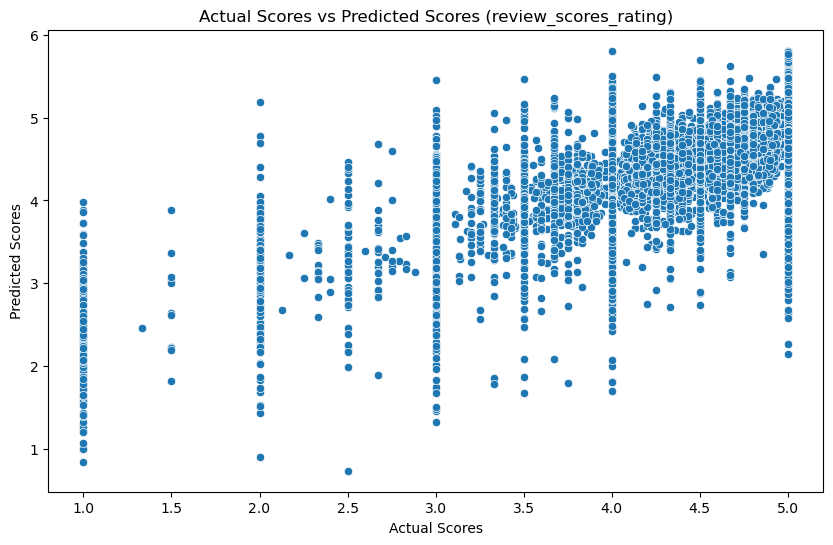

Evaluating Correlation between comments and review_scores_accuracy
Model: LinearRegression
Task: review_scores_accuracy
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




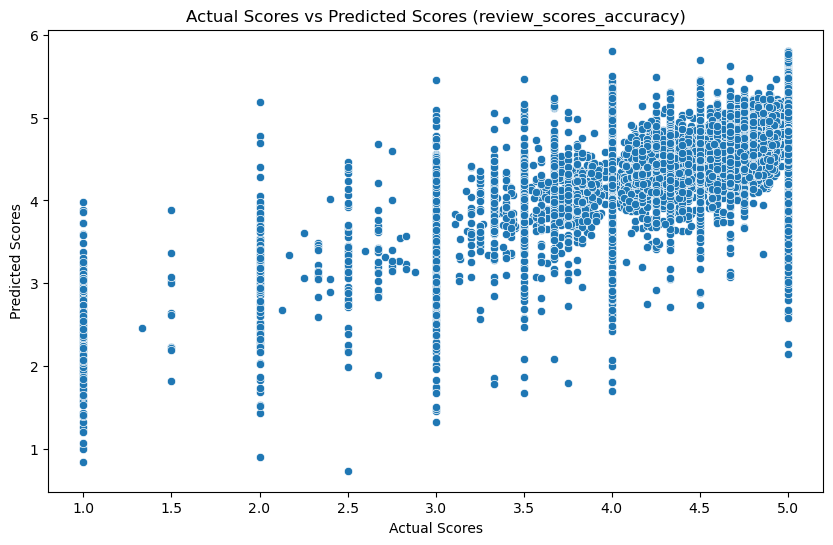

Evaluating Correlation between comments and review_scores_cleanliness
Model: LinearRegression
Task: review_scores_cleanliness
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




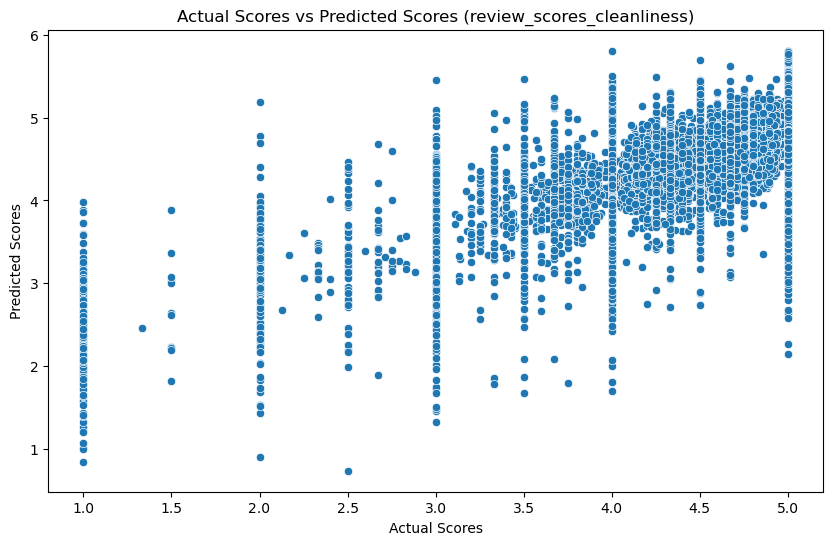

Evaluating Correlation between comments and review_scores_checkin
Model: LinearRegression
Task: review_scores_checkin
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




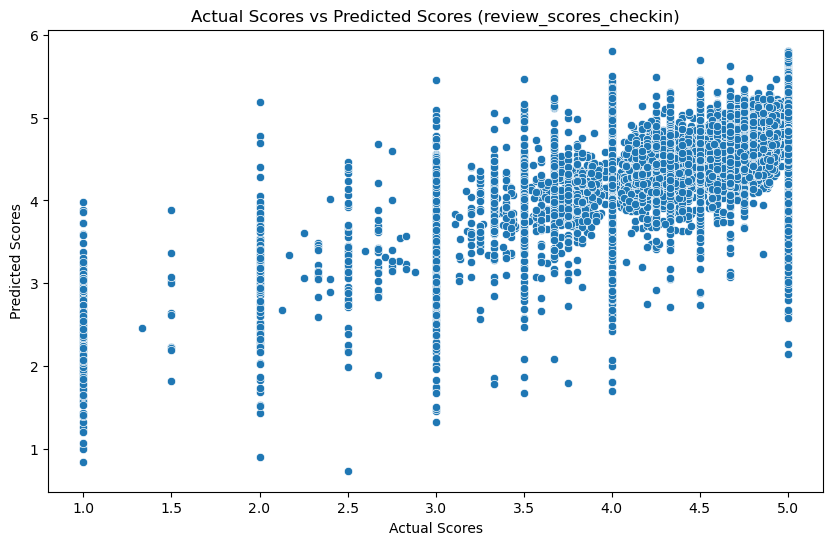

Evaluating Correlation between comments and review_scores_communication
Model: LinearRegression
Task: review_scores_communication
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




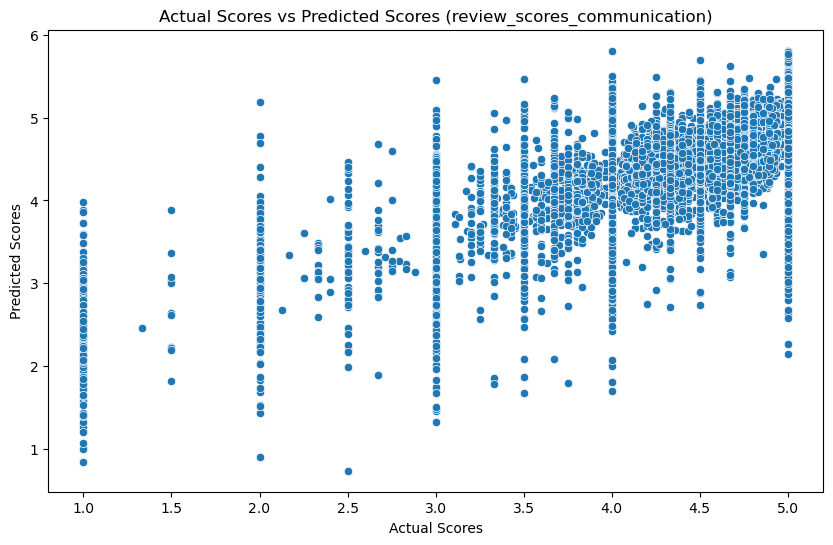

Evaluating Correlation between comments and review_scores_location
Model: LinearRegression
Task: review_scores_location
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




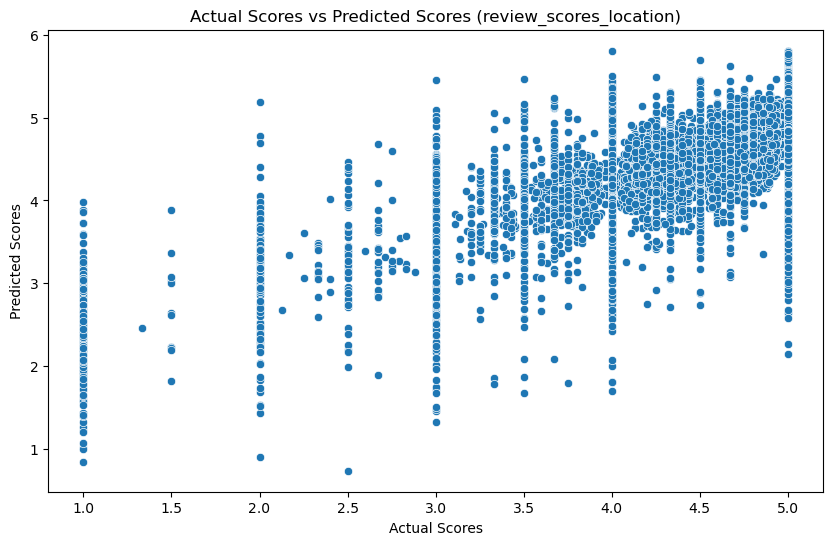

Evaluating Correlation between comments and review_scores_value
Model: LinearRegression
Task: review_scores_value
R^2 Score: 0.5553335926082361
Mean Squared Error: 0.13949429520739484
Pearson Correlation Coefficient: 0.7499294259616659




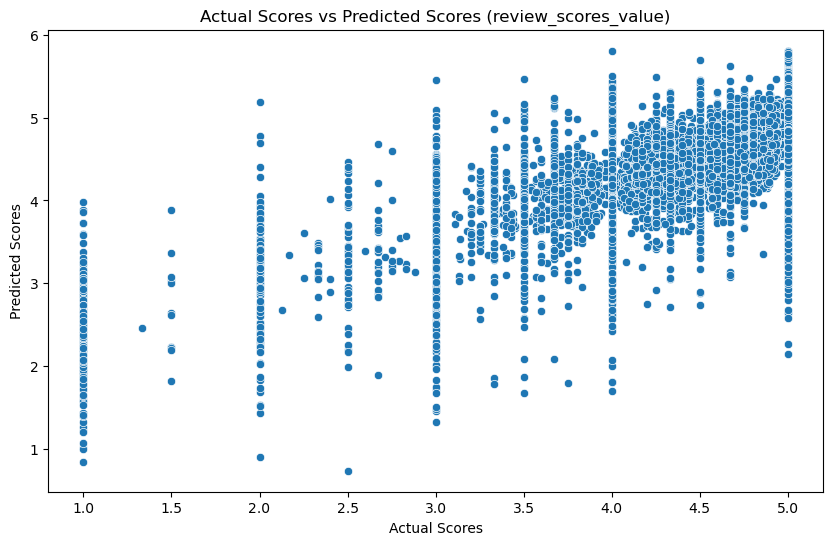

In [36]:
for col in y_cols:
	X_train_group, X_test_group, y_train_group, y_test_group = prep_dataset(X_train_embeddings, train_df["review_scores_rating"].values, X_test_embeddings, test_df["review_scores_rating"].values)
	y_test, y_pred = train_and_eval(LinearRegression, X_train_group, X_test_group, y_train_group, y_test_group, col=col)
	
	# Visualize the predicted vs actual scores
	plt.figure(figsize=(10, 6))
	sns.scatterplot(x=y_test, y=y_pred)
	plt.xlabel('Actual Scores')
	plt.ylabel('Predicted Scores')
	plt.title(f'Actual Scores vs Predicted Scores ({col})')
	plt.show()

Since the review scores given are on a per listing basis and not a per review basis, we cannot be certain whether the low correlation score is due to this difference in grouping or due to the disparity between the reviews and their score. 

## Review Summarizer
In this section, we aim to reduce the time needed for the customer to look through reviews by summarizing the reviews on a per listing basis. This is done using a pretrained Large Language Model by combining and passing in the reviews for the model to summarize. 

### Clean Up Review Data

In [7]:
from mlx_lm import load, generate

# Only perform processing on first 5 listings due to speed up preprocessing
reviews = reviews_full[reviews_full["listing_id"].isin(list(reviews_full["listing_id"].unique()[:5]))] 
reviews["language"] = reviews["comments"].apply(detect_language_with_langdetect)
reviews = reviews[reviews["language"] == "en"].reset_index()

/var/folders/kt/k34tfrn95y303r081ylcjp300000gr/T/ipykernel_15081/3515759488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["language"] = reviews["comments"].apply(detect_language_with_langdetect)


In [8]:
agg_functions = {'comments': ' \n '.join}
reviews_merge = reviews.groupby('listing_id').agg(agg_functions).reset_index()

In [9]:
reviews_merge.to_csv("input_reviews_merged.csv", index=False)
reviews_merge = pd.read_csv("input_reviews_merged.csv")

### Load Pre-trained Model and Perform Inference

In [10]:
model, tokenizer = load("mlx-community/Mistral-7B-Instruct-v0.2-8-bit-mlx")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
def summarize_reviews(reviews, model, tokenizer, temp=0):
	positive_prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction:
Based on the reviews below, identify five distinct aspects that the customers liked about the property. Return the result as up to five bullet points.

### Reviews: {reviews}

### Response:
	"""

	negative_prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction:
Based on the reviews below, identify distinct aspects that the customers disliked about the property. Return the result as up to five bullet points.

### Reviews: {reviews}

### Response:
	"""

	pos_output = generate(model, tokenizer, prompt=positive_prompt, temp=temp, max_tokens=200)
	neg_output =  generate(model, tokenizer, prompt=negative_prompt, temp=temp, max_tokens=200)
	return pos_output, neg_output


In [20]:
pos_output, neg_output = summarize_reviews(reviews_merge["comments"][0], model, tokenizer, temp=0)
print ("Strengths")
print (pos_output)
print ("\nWeaknesses")
print (neg_output)
print ("\n\n")

Strengths
* Friendly and accommodating host
* Comfortable and quiet neighborhood with excellent eateries
* Diverse with excellent ethnic eateries and good supermarkets
* Dependable transportation links
* Generous and helpful with support in finding permanent accommodation in London accommodation in London.

Weaknesses
1. The property is located in a significant distance from downtown London attractions
2. lacks adequate noise insulation in some reviews 
3. lacks mention of air conditioning or heating
4. no mention of long-decorated interior
5. no specific information about amenities or facilities or specific information about parking.


We can see the strengths and weaknesses of the listings from the cell above. Based on our preferences, we can then determine which is the best property that fits our needs. 